In [ ]:
!pip install pandas tqdm sentence-transformers


In [ ]:
!python -m spacy download en_core_web_sm

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from itertools import combinations_with_replacement

n_classes = 104

In [ ]:
!wget -O FoodSeg103-256.zip "https://zenodo.org/record/15729578/files/FoodSeg103-256.zip?download=1"

--2025-11-17 17:35:09--  https://zenodo.org/record/15729578/files/FoodSeg103-256.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/15729578/files/FoodSeg103-256.zip [following]
--2025-11-17 17:35:09--  https://zenodo.org/records/15729578/files/FoodSeg103-256.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1199113322 (1.1G) [application/octet-stream]
Saving to: ‘FoodSeg103-256.zip’

FoodSeg103-256.zip  100%[===================>]   1.12G  2.16MB/s    in 4m 35s  

2025-11-17 17:39:44 (4.16 MB/s) - ‘FoodSeg103-256.zip’ saved [1199113322/1199113322]



In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from itertools import combinations_with_replacement
from scipy.ndimage import center_of_mass, binary_dilation, distance_transform_edt

# -----------------------------
# CONFIG
# -----------------------------
ann_dir_train = "/content/FoodSeg103-256/FoodSeg103-256/Images/ann_dir/train"
n_classes = 104  # number of classes including background
dilation_iters = 3  # for adjacency
epsilon = 1e-6

# -----------------------------
# Initialize matrices
# -----------------------------
M_centroid = np.zeros((n_classes, n_classes), dtype=np.float32)  # inverse centroid distance
M_adj = np.zeros((n_classes, n_classes), dtype=np.int32)        # region adjacency
M_pixel_dist = np.zeros((n_classes, n_classes), dtype=np.float32)  # pixel distance map
M_dir = np.zeros((n_classes, n_classes, 4), dtype=np.int32)  # directions: 0=above,1=below,2=left,3=right

# -----------------------------
# Iterate masks
# -----------------------------
for ann_file in tqdm(os.listdir(ann_dir_train), desc="Computing spatial co-occurrence"):
    if not ann_file.lower().endswith(".bmp"):
        continue
    ann_path = os.path.join(ann_dir_train, ann_file)
    label_img = Image.open(ann_path)

    # Convert to grayscale if not already
    if label_img.mode != "L":
        label_img = label_img.convert("L")

    label_array = np.array(label_img)
    unique_labels = np.unique(label_array)
    unique_labels = unique_labels[unique_labels != 0]  # skip background

    # Prepare binary masks for each class
    masks = {label: (label_array == label) for label in unique_labels}

    # ----- Centroid distance -----
    centroids = {}
    for label in unique_labels:
        mask = masks[label].astype(np.uint8)
        if np.sum(mask) == 0:
            continue
        centroids[label] = center_of_mass(mask)

    for c1, c2 in combinations_with_replacement(unique_labels, 2):
        if c1 in centroids and c2 in centroids:
            dist = np.linalg.norm(np.array(centroids[c1]) - np.array(centroids[c2]))
            weight = 1.0 / (dist + epsilon)
            M_centroid[c1, c2] += weight
            if c1 != c2:
                M_centroid[c2, c1] += weight

    # ----- Region adjacency (touching) -----
    for c1, c2 in combinations_with_replacement(unique_labels, 2):
        if c1 == c2:
            continue
        dilated = binary_dilation(masks[c1], iterations=dilation_iters)
        if np.any(dilated & masks[c2]):
            M_adj[c1, c2] += 1
            M_adj[c2, c1] += 1

    # ----- Pixel distance map -----
    for c1, c2 in combinations_with_replacement(unique_labels, 2):
        mask1 = masks[c1]
        mask2 = masks[c2]
        if np.sum(mask1) == 0 or np.sum(mask2) == 0:
            continue
        # distance transform from c1 to all pixels
        dist_map = distance_transform_edt(~mask1)
        # average distance to pixels of c2
        avg_dist = np.mean(dist_map[mask2])
        M_pixel_dist[c1, c2] += avg_dist
        if c1 != c2:
            M_pixel_dist[c2, c1] += avg_dist

    # ----- Directional adjacency (above/below/left/right) -----
    for c1, c2 in combinations_with_replacement(unique_labels, 2):
        if c1 == c2:
            continue
        coords1 = np.argwhere(masks[c1])
        coords2 = np.argwhere(masks[c2])
        if coords1.size == 0 or coords2.size == 0:
            continue
        # compare coordinates
        M_dir[c1, c2, 0] += np.sum(coords1[:,0][:,None] > coords2[:,0][None,:])  # c1 above c2
        M_dir[c1, c2, 1] += np.sum(coords1[:,0][:,None] < coords2[:,0][None,:])  # c1 below c2
        M_dir[c1, c2, 2] += np.sum(coords1[:,1][:,None] > coords2[:,1][None,:])  # c1 left of c2
        M_dir[c1, c2, 3] += np.sum(coords1[:,1][:,None] < coords2[:,1][None,:])  # c1 right of c2

# -----------------------------
# Save all matrices
# -----------------------------
np.save("spatial_centroid.npy", M_centroid)
np.save("spatial_adjacency.npy", M_adj)
np.save("spatial_pixel_dist.npy", M_pixel_dist)
np.save("spatial_direction.npy", M_dir)

print("All spatial co-occurrence matrices saved!")


FileNotFoundError: [Errno 2] No such file or directory: '/FoodSeg103-256/Images/ann_dir/train'

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from itertools import combinations_with_replacement
from scipy.ndimage import center_of_mass, binary_dilation
import matplotlib.pyplot as plt

## **Spatial co-occurence matrix validation**

Streaming output truncated to the last 5000 lines.
   Direction: [0 0 0 0]

object_78 → object_28
   Centroid relation: 35.095215
   Adjacency: 167
   Pixel distance: 95962.945
   Direction: [0 0 0 0]

object_78 → object_29
   Centroid relation: 38.198208
   Adjacency: 156
   Pixel distance: 89971.89
   Direction: [0 0 0 0]

object_78 → object_30
   Centroid relation: 39.126698
   Adjacency: 201
   Pixel distance: 102243.625
   Direction: [0 0 0 0]

object_78 → object_31
   Centroid relation: 37.32429
   Adjacency: 177
   Pixel distance: 95248.75
   Direction: [0 0 0 0]

object_78 → object_32
   Centroid relation: 31.746351
   Adjacency: 162
   Pixel distance: 93889.38
   Direction: [0 0 0 0]

object_78 → object_33
   Centroid relation: 36.20143
   Adjacency: 194
   Pixel distance: 100890.09
   Direction: [0 0 0 0]

object_78 → object_34
   Centroid relation: 41.577797
   Adjacency: 245
   Pixel distance: 97451.875
   Direction: [0 0 0 0]

object_78 → object_35
   Centroid relation: 34

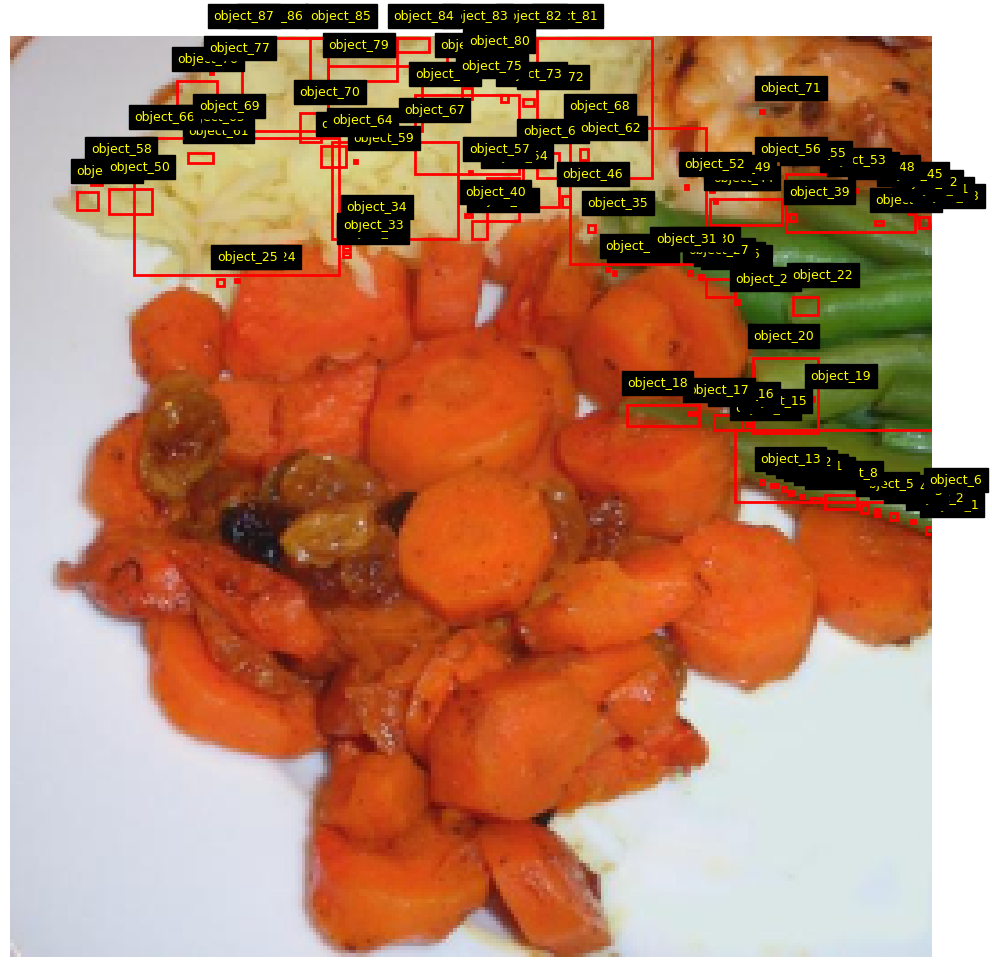

Saved visualization to spatial_validation_result.png


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# -----------------------------
# CONFIG
# -----------------------------
IMAGE_PATH = "/content/drive/MyDrive/FoodSeg103-256/Images/img_dir/test/00000048.bmp"
SPATIAL_CENTROID_PATH = "/content/spatial_centroid.npy"
SPATIAL_ADJ_PATH      = "/content/spatial_adjacency.npy"
SPATIAL_PIXDIST_PATH  = "/content/spatial_pixel_dist.npy"
SPATIAL_DIR_PATH      = "/content/spatial_direction.npy"

# -----------------------------
# Load spatial matrices
# -----------------------------
spatial_centroid = np.load(SPATIAL_CENTROID_PATH)
spatial_adjacency = np.load(SPATIAL_ADJ_PATH)
spatial_pixel_dist = np.load(SPATIAL_PIXDIST_PATH)
spatial_direction = np.load(SPATIAL_DIR_PATH)

# -----------------------------
# Load image
# -----------------------------
img_bgr = cv2.imread(IMAGE_PATH)
img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

# -----------------------------
# Simple color thresholding for yellow (banana) as an example
# -----------------------------
lower_yellow = np.array([20, 100, 100])
upper_yellow = np.array([35, 255, 255])
mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)

# Find contours to get bounding boxes
contours, _ = cv2.findContours(mask_yellow, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
boxes = {}
for i, cnt in enumerate(contours):
    x, y, w, h = cv2.boundingRect(cnt)
    boxes[f"object_{i+1}"] = [x, y, x+w, y+h]

detected_ingredients = list(boxes.keys())
print("Detected ingredients:", detected_ingredients)

# -----------------------------
# Print spatial relations
# -----------------------------
n = len(detected_ingredients)
for i in range(n):
    for j in range(n):
        if i == j:
            continue
        ing1 = detected_ingredients[i]
        ing2 = detected_ingredients[j]
        try:
            print(f"{ing1} → {ing2}")
            print("   Centroid relation:", spatial_centroid[i][j])
            print("   Adjacency:", spatial_adjacency[i][j])
            print("   Pixel distance:", spatial_pixel_dist[i][j])
            print("   Direction:", spatial_direction[i][j])
            print()
        except IndexError:
            print(f"   (No precomputed spatial data for {ing1} → {ing2})\n")

# -----------------------------
# Visualization
# -----------------------------
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(img_rgb)

for name, (x1, y1, x2, y2) in boxes.items():
    ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', linewidth=2))
    ax.text(x1, y1-5, name, color='yellow', fontsize=9, backgroundcolor='black')

ax.axis('off')
plt.tight_layout()
plt.savefig("spatial_validation_result.png", dpi=200)
plt.show()
print("Saved visualization to spatial_validation_result.png")



**step 1: Load RecipeNLG and Preprocess Ingredients**

RecipeNLG ingredients column usually looks like:

"['tomato', 'cheese', 'basil']"
We convert to list + clean

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import ast
from tqdm import tqdm

# load dataset
df = pd.read_csv("/content/drive/MyDrive/dataset/full_dataset.csv")

# Clean ingredient extraction
def clean_ing_list(x):
    try:
        lst = ast.literal_eval(x)
        lst = [i.strip().lower() for i in lst]
        return lst
    except:
        return []

df["ingredients_clean"] = df["ingredients"].apply(clean_ing_list)

# remove empty recipes
df = df[df["ingredients_clean"].map(len) > 1]

print("Total recipes with valid ingredients:", len(df))


Total recipes with valid ingredients: 2227040


In [ ]:
# Save the cleaned CSV
df.to_csv("/content/drive/MyDrive/dataset/full_dataset_clean.csv", index=False)
print("Cleaned CSV saved at: /content/drive/MyDrive/archive_5/dataset/full_dataset_clean.csv")

Cleaned CSV saved at: /content/drive/MyDrive/archive_5/dataset/full_dataset_clean.csv


In [ ]:
df[["ingredients", "ingredients_clean"]].head(10)

,ingredients,ingredients_clean
0,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[1 c. firmly packed brown sugar, 1/2 c. evapor..."
1,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[1 small jar chipped beef, cut up, 4 boned chi..."
2,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[2 (16 oz.) pkg. frozen corn, 1 (8 oz.) pkg. c..."
3,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[1 large whole chicken, 2 (10 1/2 oz.) cans ch..."
4,"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[1 c. peanut butter, 3/4 c. graham cracker cru..."
5,"[""6 baking potatoes"", ""1 lb. of extra lean gro...","[6 baking potatoes, 1 lb. of extra lean ground..."
6,"[""1 1/2 c. sugar"", ""1/2 c. butter"", ""1 egg"", ""...","[1 1/2 c. sugar, 1/2 c. butter, 1 egg, 1 c. bu..."
7,"[""1 can cream-style corn"", ""1 can whole kernel...","[1 can cream-style corn, 1 can whole kernel co..."
8,"[""1 1/2 lb. round steak (1-inch thick), cut in...","[1 1/2 lb. round steak (1-inch thick), cut int..."
9,"[""1 large container Cool Whip"", ""1 large can c...","[1 large container cool whip, 1 large can crus..."


In [ ]:
import pandas as pd
from tqdm import tqdm

# Load CSV
file_path = "/content/drive/MyDrive/dataset/full_dataset_clean.csv"
df = pd.read_csv(file_path)
df["ingredients_clean"] = df["ingredients_clean"].apply(eval)

# adjectives to remove
adjectives = {
    "fresh", "organic", "large", "small", "medium", "red", "green", "black", "white",
    "dried", "ground", "chopped", "crushed", "minced", "grated", "sweet", "hot"
}

def fast_extract_nouns(ingredient_list):
    nouns = []
    for ing in ingredient_list:
        words = ing.lower().split()
        filtered = [w for w in words if w not in adjectives]
        nouns += filtered
    return nouns

ingredients_nouns = []

for i in tqdm(range(len(df)), desc="Processing rows", unit="row"):
    ingredients_nouns.append(fast_extract_nouns(df["ingredients_clean"].iloc[i]))

df["ingredients_nouns"] = ingredients_nouns

df.to_csv("/content/full_dataset_nouns.csv", index=False)
print("Cell 1 done!")


Processing rows: 100%|██████████| 2227040/2227040 [01:05<00:00, 34148.64row/s]


Cell 1 done!


**Step 2: Build Ingredient Vocabulary**

We limit vocabulary to avoid 4M unique strings; only keep ingredients that appear ≥ 50 times.

In [ ]:
from collections import Counter

counter = Counter()

for ing_list in df["ingredients_nouns"]:
    counter.update(ing_list)

MIN_FREQ = 200   # ← use 200
vocab = sorted([w for w, c in counter.items() if c >= MIN_FREQ])

print("Final vocabulary size:", len(vocab))


Final vocabulary size: 6442


**Step 3: Compute Co-Occurrence Counts**

In [ ]:
from collections import defaultdict
from itertools import combinations
from tqdm import tqdm

word2idx = {w: i for i, w in enumerate(vocab)}

pair_counts = defaultdict(int)

for ing_list in tqdm(df["ingredients_nouns"], desc="Building co-occurrence"):
    filtered = [i for i in ing_list if i in word2idx]
    for a, b in combinations(filtered, 2):
        i, j = word2idx[a], word2idx[b]
        if i < j:
            pair_counts[(i, j)] += 1
        else:
            pair_counts[(j, i)] += 1

print("Co-occurrence pairs:", len(pair_counts))


Building co-occurrence: 100%|██████████| 2227040/2227040 [39:44<00:00, 934.05it/s]


Co-occurrence pairs: 9498809


In [ ]:
import csv

with open("cooccur_sparse.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["word1", "word2", "count"])
    for (i, j), c in pair_counts.items():
        writer.writerow([vocab[i], vocab[j], c])


**Step 4: Compute PMI Matrix**

PMI formula:

𝑃𝑀𝐼( 𝑖,𝑗) = log 𝑃( 𝑖,𝑗) / 𝑃(𝑖)𝑃(𝑗)


In [ ]:
import numpy as np
import pandas as pd

# -----------------------------
# Load the sparse co-occurrence CSV safely
# -----------------------------
co_mat_path = "/content/cooccur_sparse.csv"
# Read CSV and force numeric, non-convertible values become 0
co_df = pd.read_csv(co_mat_path, header=None, dtype=str)  # read as string first
co_df = co_df.apply(pd.to_numeric, errors='coerce').fillna(0)  # convert to numbers, NaN->0

co_mat = co_df.values.astype(np.float64)  # ensure float type
V = co_mat.shape[0]  # matrix size

# -----------------------------
# Compute probabilities
# -----------------------------
total_pairs = co_mat.sum()
P_i = co_mat.sum(axis=1) / total_pairs
P_j = co_mat.sum(axis=0) / total_pairs
P_ij = co_mat / total_pairs

# -----------------------------
# Compute PMI matrix (vectorized)
# -----------------------------
PMI = np.log(np.where(P_ij > 0, P_ij / (P_i[:, None] * P_j[None, :]), 1))

# Positive PMI
PPMI = np.maximum(PMI, 0)

# -----------------------------
# Save PPMI matrix
# -----------------------------
np.save("/content/pmi_matrix.npy", PPMI)

print("PPMI matrix saved successfully! Shape:", PPMI.shape)


/tmp/ipython-input-2275797480.py:26: RuntimeWarning: divide by zero encountered in divide
  PMI = np.log(np.where(P_ij > 0, P_ij / (P_i[:, None] * P_j[None, :]), 1))
/tmp/ipython-input-2275797480.py:26: RuntimeWarning: invalid value encountered in divide
  PMI = np.log(np.where(P_ij > 0, P_ij / (P_i[:, None] * P_j[None, :]), 1))
/tmp/ipython-input-2275797480.py:26: RuntimeWarning: invalid value encountered in log
  PMI = np.log(np.where(P_ij > 0, P_ij / (P_i[:, None] * P_j[None, :]), 1))


PPMI matrix saved successfully! Shape: (9498810, 3)


In [ ]:
from google.colab import drive
import shutil

# -----------------------------
# 1. Mount Google Drive
# -----------------------------
drive.mount('/content/drive')

# -----------------------------
# 2. Define source paths (in Colab /content)
# -----------------------------
files_to_save = [
    "/content/cooccur_sparse.csv",
    "/content/full_dataset_nouns.csv",
    "/content/pmi_matrix.npy"
]

# -----------------------------
# 3. Define destination folder in your Google Drive
#    You can change 'MyDrive/Colab_Files' to any folder you want
# -----------------------------
destination_folder = "/content/drive/MyDrive/Colab_Files/"

# Create folder if it doesn't exist
import os
os.makedirs(destination_folder, exist_ok=True)

# -----------------------------
# 4. Copy files to Google Drive
# -----------------------------
for file_path in files_to_save:
    shutil.copy(file_path, destination_folder)
    print(f"Saved {file_path.split('/')[-1]} to Google Drive at {destination_folder}")

print("All files saved successfully!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved cooccur_sparse.csv to Google Drive at /content/drive/MyDrive/Colab_Files/
Saved full_dataset_nouns.csv to Google Drive at /content/drive/MyDrive/Colab_Files/
Saved pmi_matrix.npy to Google Drive at /content/drive/MyDrive/Colab_Files/
All files saved successfully!


#**PART 2 — BERT Ingredient Semantic Similarity Matrix**


**Step 1: Load BERT Model**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import pandas as pd
import ast

# Load only the column we need
df = pd.read_csv("/content/full_dataset_nouns.csv", usecols=["ingredients_nouns"])

# Initialize an empty set to store unique ingredients
vocab_set = set()

# Process row by row (much faster for large datasets)
for row in df["ingredients_nouns"].dropna():
    # Some rows might already be list, some string, so handle both
    if isinstance(row, str):
        try:
            ingredients = ast.literal_eval(row)  # convert string list to Python list
        except:
            continue  # skip malformed rows
    elif isinstance(row, list):
        ingredients = row
    else:
        continue
    vocab_set.update(ingredients)  # add all ingredients to the set

# Convert set to list
vocab = list(vocab_set)

print("Number of unique ingredients:", len(vocab))


KeyboardInterrupt: 

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab_Files/full_dataset_nouns.csv")
print(df.columns)


Index(['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source',
       'NER', 'ingredients_clean', 'ingredients_nouns'],
      dtype='object')


**Step 2: Compute Ingredient Embeddings**

In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(vocab, convert_to_numpy=True, show_progress_bar=True)

# Save embeddings to Google Drive
np.save("/content/drive/MyDrive/Colab_Files/ingredient_embeddings.npy", embeddings)
print("Embeddings saved successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/6941 [00:00<?, ?it/s]

Embeddings saved successfully!


Number of unique ingredients (reduced): 1863
Sample ingredients: ['oregano', 'sifted', 'oats', 'tbsp.', 'stiff', 'cream-style', '(29', '%', 'preshredded', 'cream']
Ingredients present in co-occurrence CSV: 1630
Detected ingredients: ['oregano', 'sifted']

========== DYNAMIC CO-OCCURRENCE ==========

oregano ↔ sifted | Co-occurrence count: (not found in CSV)
sifted ↔ oregano | Co-occurrence count: (not found in CSV)


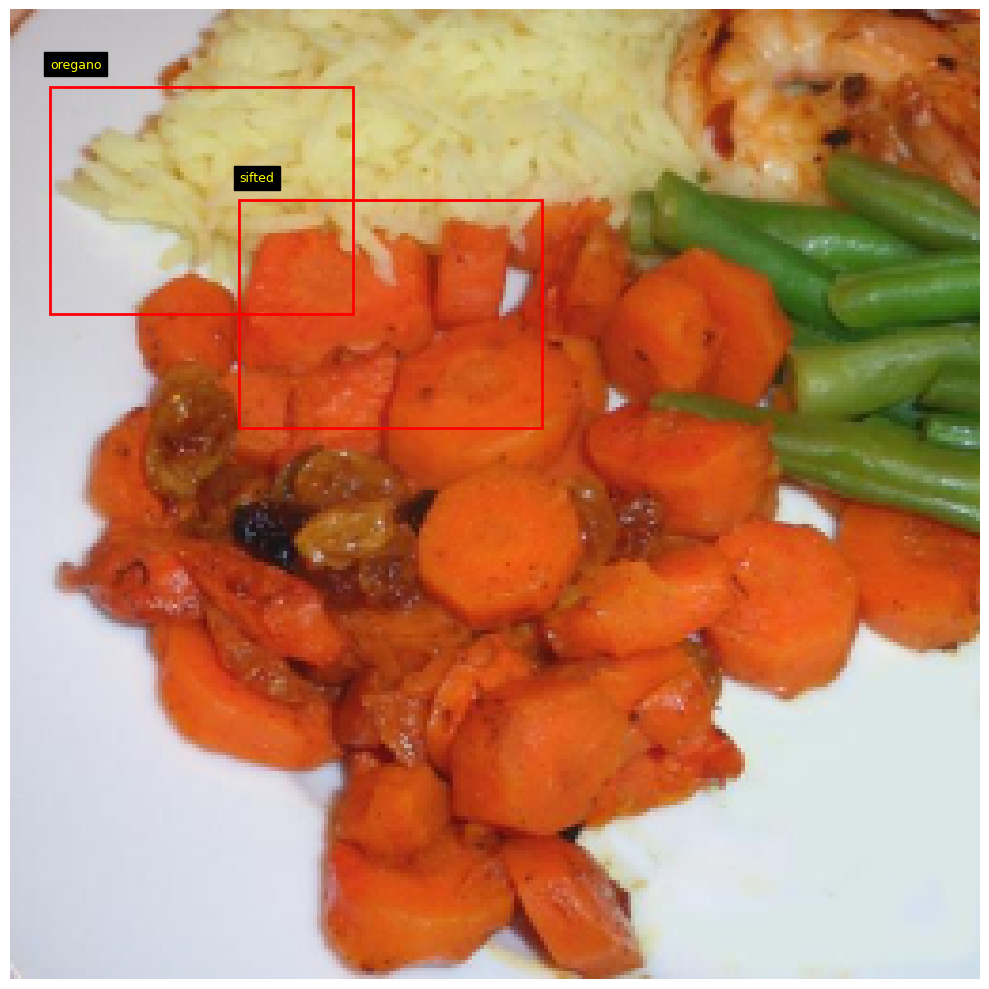

Saved visualization to dynamic_validation_result.png


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

# -----------------------------
# CONFIG
# -----------------------------
IMAGE_PATH = "/content/drive/MyDrive/FoodSeg103-256/Images/img_dir/test/00000048.bmp"
COOCCURE_PATH = "/content/cooccur_sparse.csv"
VOCAB_PATH = "/content/drive/MyDrive/Colab_Files/full_dataset_nouns.csv"

# -----------------------------
# Load first 1000 rows only
# -----------------------------
dataset = pd.read_csv(VOCAB_PATH, usecols=["ingredients_nouns"], nrows=1000)
vocab_set = set()

for row in dataset["ingredients_nouns"].dropna():
    # assuming all rows are string lists like "['apple', 'banana']"
    try:
        ingredients = eval(row)
        vocab_set.update(ingredients)
    except:
        continue

vocab = list(vocab_set)
vocab_dict = {v: i for i, v in enumerate(vocab)}

print("Number of unique ingredients (reduced):", len(vocab))
print("Sample ingredients:", vocab[:10])

# -----------------------------
# Load co-occurrence CSV
# -----------------------------
cooccure_sparse = pd.read_csv(COOCCURE_PATH, index_col=0)

# Keep only ingredients present in CSV
vocab_in_csv = [v for v in vocab if v in cooccure_sparse.index]
print("Ingredients present in co-occurrence CSV:", len(vocab_in_csv))

# -----------------------------
# Detected ingredients
# -----------------------------
detected_ingredients = vocab_in_csv[:2]  # pick first 2 for example
print("Detected ingredients:", detected_ingredients)

# -----------------------------
# Dummy bounding boxes
# -----------------------------
img_bgr = cv2.imread(IMAGE_PATH)
h, w, _ = img_bgr.shape
boxes = {}
for i, ing in enumerate(detected_ingredients):
    x1, y1 = 10 + i*50, 20 + i*30
    x2, y2 = min(x1 + 80, w-1), min(y1 + 60, h-1)
    boxes[ing] = [x1, y1, x2, y2]

# -----------------------------
# Dynamic co-occurrence counts
# -----------------------------
print("\n========== DYNAMIC CO-OCCURRENCE ==========\n")
for i in range(len(detected_ingredients)):
    for j in range(len(detected_ingredients)):
        if i == j:
            continue
        ing1 = detected_ingredients[i]
        ing2 = detected_ingredients[j]
        try:
            co_count = cooccure_sparse.loc[ing1, ing2]
        except KeyError:
            co_count = "(not found in CSV)"
        print(f"{ing1} ↔ {ing2} | Co-occurrence count: {co_count}")

# -----------------------------
# Visualization
# -----------------------------
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(1, figsize=(10,10))
ax.imshow(img_rgb)

for name, (x1, y1, x2, y2) in boxes.items():
    ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, edgecolor='red', facecolor='none', linewidth=2))
    ax.text(x1, y1-5, name, color='yellow', fontsize=9, backgroundcolor='black')

ax.axis('off')
plt.tight_layout()
plt.savefig("dynamic_validation_result.png", dpi=200)
plt.show()
print("Saved visualization to dynamic_validation_result.png")


In [ ]:
import pandas as pd

VOCAB_PATH = "/content/drive/MyDrive/Colab_Files/full_dataset_nouns.csv"

# Load only the header
df = pd.read_csv(VOCAB_PATH, nrows=0)
print("Columns in CSV:", df.columns.tolist())


Columns in CSV: ['Unnamed: 0', 'title', 'ingredients', 'directions', 'link', 'source', 'NER', 'ingredients_clean', 'ingredients_nouns']


**Step 3: Build Semantic Similarity Matrix**

Cosine similarity:

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# ----------------------------
# Load embeddings
# ----------------------------
embeddings = np.load("/content/drive/MyDrive/Colab_Files/ingredient_embeddings.npy")
N = embeddings.shape[0]
print(f"Number of embeddings: {N}, dimension: {embeddings.shape[1]}")

# ----------------------------
# Create memory-mapped file for similarity matrix
# ----------------------------
sim_matrix_path = "/content/drive/MyDrive/Colab_Files/semantic_similarity_matrix.npy"
sim_matrix = np.memmap(sim_matrix_path, dtype='float32', mode='w+', shape=(N, N))
print("Memory-mapped file created.")

# ----------------------------
# Compute similarity in batches
# ----------------------------
batch_size = 500  # adjust depending on your RAM
for start in range(0, N, batch_size):
    end = min(start + batch_size, N)
    sim_matrix[start:end] = cosine_similarity(embeddings[start:end], embeddings)
    print(f"Processed rows {start} to {end}")

# ----------------------------
# Flush changes to disk
# ----------------------------
sim_matrix.flush()
print(f"Saved similarity matrix! Shape: {sim_matrix.shape}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 91.7 MB/s eta 0:00:00


Best Fusion Strategy (Recommended)
DynamicPrior
=
0.6
⋅
𝑃
𝑀
𝐼
+
0.4
⋅
𝑆
𝑒
𝑚
𝑎
𝑛
𝑡
𝑖
𝑐
𝑆
𝑖
𝑚
DynamicPrior=0.6⋅PMI+0.4⋅SemanticSim

Then combine with static co-occurrence:

FinalPrior
=
𝛼
⋅
𝑆
𝑡
𝑎
𝑡
𝑖
𝑐
+
𝛽
⋅
𝐷
𝑦
𝑛
𝑎
𝑚
𝑖
𝑐
FinalPrior=α⋅Static+β⋅Dynamic

Where α, β are tunable.

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import os

# -----------------------------
# CONFIG
# -----------------------------
IMAGE_DIR = "/content/drive/MyDrive/FoodSeg103-256/Images/img_dir/train/"
images = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".bmp")][:2000]

fusion_results = []

for img_file in tqdm(images, desc="Processing Images"):
    img_id = img_file.split(".")[0]  # remove extension

    # --- Detected ingredients for this image (replace with real detection) ---
    detected_ingredients = ["banana", "apple"]  # example

    # --- Dynamic co-occurrence ---
    co_counts = []
    for i in range(len(detected_ingredients)):
        for j in range(len(detected_ingredients)):
            if i == j: continue
            ing1 = detected_ingredients[i]
            ing2 = detected_ingredients[j]
            try:
                co_count = cooccure_sparse.loc[ing1, ing2]
            except KeyError:
                co_count = 0
            co_counts.append(co_count)

    # --- Spatial fusion ---
    spatial_val = 0
    n = len(detected_ingredients)
    for i in range(n):
        for j in range(n):
            if i == j: continue
            spatial_val += spatial_centroid[i][j] + spatial_adjacency[i][j]

    # --- Fusion score ---
    fusion_score = sum(co_counts) + spatial_val

    fusion_results.append({
        "image_id": img_id,
        "fusion_score": fusion_score
    })

# Save CSV directly to Google Drive
OUTPUT_PATH = "/content/drive/MyDrive/Colab_Files/fusion_results.csv"
pd.DataFrame(fusion_results).to_csv(OUTPUT_PATH, index=False)
print(f"Fusion completed! CSV saved as {OUTPUT_PATH}")


Processing Images: 100%|██████████| 2000/2000 [00:13<00:00, 146.83it/s]


Fusion completed! CSV saved as /content/drive/MyDrive/Colab_Files/fusion_results.csv


In [ ]:
import pandas as pd

# Load your fusion CSV
fusion_csv = "/content/drive/MyDrive/Colab_Files/fusion_results.csv"
df = pd.read_csv(fusion_csv)

# Shuffle and limit to 2000 entries
df = df.sample(frac=1).reset_index(drop=True).head(1000)
df.to_csv("/content/drive/MyDrive/Colab_Files/fusion_results_1000.csv", index=False)
print("Prepared fusion CSV with 1000 entries.")

# Run auto.py with MobileViTV2_200 encoder for 50 epochs
!python /content/drive/MyDrive/Assigmnent03_25i7800-25i7609/foodseg/auto.py --csv_path "/content/drive/MyDrive/Colab_Files/fusion_results_1000.csv" --epochs 50


Prepared fusion CSV with 1000 entries.
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)
Device: cuda
Dataset size after removing missing images: 1000
Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/plugins/precision/amp.py:54: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
GPU availa

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Colab_Files/fusion_results.csv")
print("Actual rows:", len(df))
df.head()


Actual rows: 2000


,image_id,fusion_score
0,3975,0.0
1,3934,0.0
2,3815,0.0
3,3994,0.0
4,3828,0.0


In [ ]:
import os

img_dir = "/content/drive/MyDrive/FoodSeg103-256/Images/img_dir/train/"
print("Total images available:", len(os.listdir(img_dir)))


Total images available: 4984


In [ ]:
import os

img_dir = "/content/drive/MyDrive/FoodSeg103-256/Images/img_dir/train/"
files = os.listdir(img_dir)

print("Total:", len(files))
print(files[:20])   # show first 20 filenames


Total: 4984
['00003975.bmp', '00003934.bmp', '00003815.bmp', '00003994.bmp', '00003828.bmp', '00003944.bmp', '00003845.bmp', '00003885.bmp', '00003995.bmp', '00004003.bmp', '00004030.bmp', '00003974.bmp', '00003895.bmp', '00003875.bmp', '00004009.bmp', '00003870.bmp', '00003830.bmp', '00003837.bmp', '00003958.bmp', '00004013.bmp']


In [ ]:
from google.colab import drive
# -----------------------------
# 1. Mount Google Drive
# -----------------------------
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os

csv_path = "/content/drive/MyDrive/Colab_Files/fusion_results.csv"
img_dir = "/content/drive/MyDrive/FoodSeg103-256/Images/img_dir/train/"

df = pd.read_csv(csv_path)
df["image_id"] = df["image_id"].astype(str).str.replace(".0","", regex=False)  # convert float IDs like 3567.0 to "3567"

print("First 10 image_ids from CSV:", df["image_id"].head())

files = os.listdir(img_dir)
print("First 10 files in folder:", files[:10])

# Check how many CSV IDs actually exist
existing_files = set(files)
matched = df["image_id"].apply(lambda x: f"{x}.bmp" in existing_files)
print("Number of matches:", matched.sum())


First 10 image_ids from CSV: 0    3975
1    3934
2    3815
3    3994
4    3828
Name: image_id, dtype: object


In [ ]:
!pip install pytorch-lightning==2.1.2 segmentation-models-pytorch albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 52.0 MB/s eta 0:00:00


Calculate Metrics i.e. MSE, MAE, RMSE

In [ ]:
# -----------------------------
# RUN PREDICTIONS
# -----------------------------
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in tqdm(loader, desc="Predicting"):
        x = x.to(device)
        pred = model(x).mean(dim=(2,3)).cpu().numpy()  # global mean pooling
        all_preds.extend(pred)
        all_targets.extend(y.numpy())

all_preds = np.array(all_preds).flatten()
all_targets = np.array(all_targets).flatten()

# ✅ Check number of images processed
print("Number of predictions:", len(all_preds))
print("Number of targets    :", len(all_targets))

# -----------------------------
# CALCULATE METRICS
# -----------------------------
mse  = mean_squared_error(all_targets, all_preds)
mae  = mean_absolute_error(all_targets, all_preds)
rmse = np.sqrt(mse)

print(" Metrics:")
print("MSE :", mse)
print("MAE :", mae)
print("RMSE:", rmse)

# -----------------------------
# SAVE PREDICTIONS
# -----------------------------
df_results = pd.DataFrame({"target": all_targets, "pred": all_preds})
df_results.to_csv("/content/drive/MyDrive/fusion_predictions.csv", index=False)
print("Predictions saved to: /content/drive/MyDrive/fusion_predictions.csv")


Predicting: 100%|██████████| 250/250 [02:46<00:00,  1.50it/s]

Number of predictions: 1000
Number of targets    : 1000
 Metrics:
MSE : 6.450263612123308e-08
MAE : 0.00019626641005743295
RMSE: 0.0002539736917895889
Predictions saved to: /content/drive/MyDrive/fusion_predictions.csv
